<a href="https://colab.research.google.com/github/KevinYoung18/3700-1/blob/master/hair_skin_segmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from skimage.util import random_noise
from keras import backend as K
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Input, Lambda, ZeroPadding2D, concatenate
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread_collection
print(tf.__version__)

Using TensorFlow backend.


2.0.0


In [0]:
#function to import images
def import_images(path, size=(256,256,3), suffix='.jpg'):
  names = [f for f in os.listdir(path) if f.endswith(suffix)]
  names = sorted(names, key=lambda s:int(s.split('_')[2].split('.')[0]))

  images = Image.open(os.path.join(path,names[0]))
  images = np.array(images.resize(size[:2])).reshape((1,size[0],size[1],size[2]))
  for name in tqdm(names[1:]):
    img = Image.open(os.path.join(path,name))
    img = np.array(img.resize(size[:2])) 
    images = np.vstack((images, img.reshape((1,size[0],size[1],size[2]))))
  
  return images


In [0]:
'''
training_images = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_hair_skin/images")
training_masks = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_hair_skin/masks", size=(256,256,3),  suffix='.ppm')
validation_images = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/validation_hair_skin/images")
validation_masks = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/validation_hair_skin/masks", size=(256,256,3), suffix='.ppm')
'''

'\ntraining_images = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_hair_skin/images")\ntraining_masks = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_hair_skin/masks", size=(256,256,3),  suffix=\'.ppm\')\nvalidation_images = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/validation_hair_skin/images")\nvalidation_masks = import_images("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/validation_hair_skin/masks", size=(256,256,3), suffix=\'.ppm\')\n'

In [0]:
'''
x = np.vstack((training_images,validation_images))
y = np.vstack((training_masks, validation_masks))
'''

'\nx = np.vstack((training_images,validation_images))\ny = np.vstack((training_masks, validation_masks))\n'

In [0]:
'''
np.save("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_images.npy", x)
np.save("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_masks.npy", y)
'''

'\nnp.save("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_images.npy", x)\nnp.save("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_masks.npy", y)\n'

In [0]:

x = np.load("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_images.npy", allow_pickle=True)/255
y = np.load("/content/drive/My Drive/Hair segementation/training_validation_Hair_Skin_Masks/training_masks.npy", allow_pickle=True)/255

In [0]:


x_train, x_val =np.split(x, [1800])
y_train, y_val = np.split(y, [1800])

x_train = np.vstack((np.flip(x_train,axis=2),x_train))
x_val = np.vstack((np.flip(x_val,axis=2),x_val))
y_train = np.vstack((np.flip(y_train,axis=2),y_train))
y_val = np.vstack((np.flip(y_val,axis=2),y_val))

print(x_train.shape , x_val.shape)

(3600, 256, 256, 3) (400, 256, 256, 3)


In [0]:
#implementation of dice metric
def dice(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


In [0]:
#create unet model
inputs = Input((256, 256, 3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(3, (1, 1), activation='softmax') (c9)



In [0]:
checkpoint= tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/Hair segementation/weights_{epoch:02d}.h5",
                                          save_weights_only=True,
                                          mode='auto', 
                                          save_freq='epoch',
                                          verbose = 0)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

optimizer = tf.keras.optimizers.Adam(learning_rate=.0005)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=[dice]
              )



#train model
model.fit( 
    x_train,
    y_train,
    validation_data =(x_val, y_val),
    batch_size=16,
    epochs=100,
    callbacks=[checkpoint]
    )



Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 31s 9ms/sample - loss: 0.4208 - dice: 0.9094 - val_loss: 0.3195 - val_dice: 0.9331
Epoch 2/100
3600/3600 [==============================] - 25s 7ms/sample - loss: 0.2721 - dice: 0.9433 - val_loss: 0.3500 - val_dice: 0.9283
Epoch 3/100
3600/3600 [==============================] - 25s 7ms/sample - loss: 0.2365 - dice: 0.9508 - val_loss: 0.2781 - val_dice: 0.9447
Epoch 4/100
3600/3600 [==============================] - 25s 7ms/sample - loss: 0.2000 - dice: 0.9585 - val_loss: 0.2086 - val_dice: 0.9578
Epoch 5/100
3600/3600 [==============================] - 25s 7ms/sample - loss: 0.1681 - dice: 0.9652 - val_loss: 0.1819 - val_dice: 0.9641
Epoch 6/100
3600/3600 [==============================] - 25s 7ms/sample - loss: 0.1488 - dice: 0.9691 - val_loss: 0.1690 - val_dice: 0.9678
Epoch 7/100
3600/3600 [==============================] - 25s 7ms/sample - loss: 0.1325 - dice: 0.9725 - val_loss:

KeyboardInterrupt: ignored

In [0]:
#load best weights from training
model.load_weights("/content/drive/My Drive/Hair segementation/weights_28.h5")

In [0]:
def import_celeb_images(path, size=(256,256,3), suffix='.jpg'):
  names = [f for f in os.listdir(path) if f.endswith(suffix)]
  names = sorted(names, key=lambda s:int(s.split('.')[0]))
  images = Image.open(os.path.join(path,names[0]))
  print(images.size)
  images = np.array(images.resize(size[:2])).reshape((1,size[0],size[1],size[2]))
  for name in tqdm(names[1:]):
    img = Image.open(os.path.join(path,name))
    print(img.size)
    img = np.array(img.resize(size[:2])) 
    images = np.vstack((images, img.reshape((1,size[0],size[1],size[2]))))
  
  return images

In [0]:
celeb_imgs = import_celeb_images('/content/drive/My Drive/Hair segementation/celeb_test')


100%|██████████| 49/49 [00:00<00:00, 324.66it/s]

(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)
(178, 218)


In [0]:
np.save("/content/drive/My Drive/Hair segementation/additional data/celeb_test_array.npy", celeb_imgs )

In [0]:
test_results = model.predict(celeb_imgs/255)


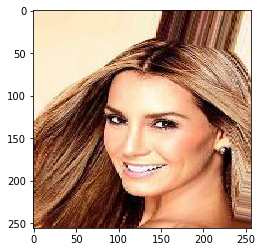

In [0]:
plt.imshow(celeb_imgs[0])

In [0]:
test_results =(test_results > 0.5).astype(np.uint8).astype(np.float32)

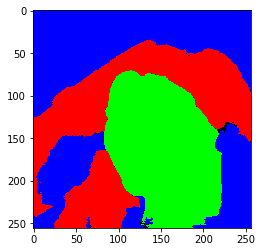

In [0]:
plt.imshow(test_results[0])

In [0]:
test_results = test_results.astype(np.uint8)

In [0]:
#save images as .jpg
for i in tqdm(range(50)):
  path= "/content/drive/My Drive/Hair segementation/celeb_mask/mask_" + str(1+i) + ".jpg"
  img = Image.fromarray((test_results[i] * 255).reshape((256,256,3)))
  img = img.resize((178, 218))
  img.save(path)


100%|██████████| 50/50 [00:00<00:00, 177.47it/s]